# FINM 33150 Homework 2 Simple Spread Trading
### Huayu Zhu (huayuz) - UCID: 12413518
### Date: Jan 16th, 2024 

## 1. Introduction 

### 1.1 Motivation 

In this notebook, we utilize data from Quandl EOD database to get RTH-XRT(8) pair to implement the spread-reversion trading strategy. Our trading date starts from Jan 01, 2022 to Nov 25, 2023. The main focus of our study is on the return on capital and we will try to find parameters that lead to the highest returns. 

Parameters we investigated are: 
* upper threshold: g
* lower threshold: j 
* stop loss: s 
* transaction cost: $\zeta$ [0,0.00001]
* time period: M 

I will majorly use the text representation just to make sure clarity. 

Then I look into correlations to Fama French factor returns and SVOL levels. 

### 1.2 Packages & Key Constants & Helper Functions

#### Packages 

In [194]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm
import plotly.express as px
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import coint
from dataclasses import dataclass
from enum import Enum
from statsmodels.regression.rolling import RollingOLS

#### Key Constants 

In [2]:
myAPIkey = 'yourAPI'
quandl.ApiConfig.api_key = myAPIkey
start_date = '2021-12-02'
end_date = '2023-11-15'

ETF = ['SVOL','RTH','XRT']

trading_start_date = '2022-01-01'
trading_end_date = '2023-11-15'

#### Helper Functions 

##### Get ETF Data 

In [3]:
def get_ETF_data(name, start, end): 
    raw_data = quandl.get_table('QUOTEMEDIA/PRICES', ticker = name, date = {'gte':start, 'lte':end}) 

    # arrange the df in time series 
    df = raw_data.sort_values(by = 'date')

    # set time as index
    df.set_index('date', inplace = True)

    # calculate the estimated daliy dollar volume 
    df['estimated_dollar_volume'] = df['adj_close'] * df['adj_volume']

    # calculate N_t 
    df['N_t'] = df['estimated_dollar_volume'].shift(1).rolling(15).median() 

    df  =  df.loc[:,['adj_close','estimated_dollar_volume','N_t','adj_volume']]
    df.rename(columns = {'adj_close': name+'_adj_close', 'estimated_dollar_volume': name+'_estimated_dollar_volume', 'N_t': name+'_N_t','adj_volume': name + '_adj_volume'}, inplace = True)

    return df

##### Combine ETF data 

In [4]:
def combine_ETF_data(ETF_list): 
    df_list = list()
    for name in ETF_list: 
        df = get_ETF_data(name, start_date, end_date)
        df_list.append(df)
    
    # check whether the index are the same, if so, combine them together 
    if all(df_list[0].index.equals(other_df.index) for other_df in df_list[1:]):
        data = pd.concat(df_list, axis= 1)
        return data 
    else: 
        print('need further data cleaning process')

##### Get Fama-French factors data 

In [5]:
def get_Factors_data(): 
    df = pd.read_csv('Developed_3_Factors_Daily.csv', skiprows=6)

    # set the time as index 
    df.rename(columns = {'Unnamed: 0': 'date'}, inplace = True)
    df = df.set_index('date')

    # set the string time as datetime 
    df.index = pd.to_datetime(df.index, format='%Y%m%d')

    # slice the time interval 
    df = df.loc[start_date:end_date, :]

    return df 

##### Spread Trading Strategy 

In [104]:
def spread_trading_strategy(data, M, upper_threshold, lower_threshold, stop_loss, transaction_cost_proportional, trading_start_date, trading_end_date, draw_graph = False):

    # Calculate M-day returns
    data['RTH_Return'] = data['RTH_price'].pct_change(periods=M)
    data['XRT_Return'] = data['XRT_price'].pct_change(periods=M)
    data['Return_Spread'] = data['RTH_Return'] - data['XRT_Return']

    # Determine the capital K
    capital = data['N_t'].max() * 2

    # Check month ends or not 
    month_ends = pd.date_range(trading_start_date,trading_end_date, freq="BM").date 
    data['IsMonthEnd'] = ETF_data_trading.index.isin(month_ends)

    next_start_date = pd.to_datetime(trading_start_date)

    # Add a new column to track if the position has changed
    data['Position_Changed'] = False
    data['stop_loss_triggered'] = False
    data['trade_signal'] = 0 

    # Initialize columns for position and PnL tracking
    columns = ['Spread_Position', 'RTH_Position', 'XRT_Position', 'Gross_Traded_Cash',
               'PnL', 'Cumulative_PnL', 'Trading_Cost', 'Return_on_Capital','Cumulative_Return_on_Capital']
    for col in columns:
        data[col] = 0.0

    # Ensure the index is a DatetimeIndex
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    data = data.loc[trading_start_date:trading_end_date]

    for i in range(1, len(data)):
        current_date = data.index[i]

        if current_date < next_start_date: #stop loss start 
            data = calculate_daily_pnl(data, current_date,transaction_cost_proportional)
            continue

        # Entry conditions
        current_position = data.loc[data.index[i-1], 'Spread_Position']
        if current_position == 0:  # No current position
            if abs(data.loc[current_date, 'Return_Spread']) > upper_threshold:
                if data.loc[current_date, 'Return_Spread'] > upper_threshold:
                    # sell the spread (Long RTH and Short XRT)
                    data = enter_position(data, current_date, -1,transaction_cost_proportional)
                elif data.loc[current_date, 'Return_Spread'] < -upper_threshold:
                    data = enter_position(data, current_date, 1,transaction_cost_proportional)
        elif current_position == 1: # already bought one spread 
            if data.loc[current_date, 'IsMonthEnd'] == True or str(current_date) >= trading_end_date:
                data = exist_position(data, current_date, -1,transaction_cost_proportional)
            elif data.loc[data.index[i-1], 'PnL'] < -stop_loss * data.loc[data.index[i-1], 'Gross_Traded_Cash']: # stop loss, skip 
                next_month_start = (current_date + pd.offsets.BMonthEnd(1)) + pd.offsets.BDay(1)
                next_start_date = max(next_start_date, next_month_start)
                data = exist_position(data, current_date, -1,transaction_cost_proportional)  
                data.loc[current_date,'stop_loss_triggered'] =True 
            elif abs(data.loc[current_date, 'Return_Spread']) < lower_threshold:
                data = exist_position(data, current_date, -1,transaction_cost_proportional)
            else: 
                data = enter_position(data, current_date, 0,transaction_cost_proportional)
        elif current_position == -1: # already short one spread
            if data.loc[current_date, 'IsMonthEnd'] == True or str(current_date) >= trading_end_date:
                data = exist_position(data, current_date, 1,transaction_cost_proportional)
            elif data.loc[data.index[i-1], 'PnL'] < -stop_loss * data.loc[data.index[i-1], 'Gross_Traded_Cash']:
                next_month_start = (current_date + pd.offsets.BMonthEnd(1)) + pd.offsets.BDay(1)
                next_start_date = max(next_start_date, next_month_start)
                data = exist_position(data, current_date, 1,transaction_cost_proportional) 
                data.loc[current_date,'stop_loss_triggered'] =True 
            elif abs(data.loc[current_date, 'Return_Spread']) < lower_threshold:
                data = exist_position(data, current_date, 1,transaction_cost_proportional)
            else: 
                data = enter_position(data, current_date, 0,transaction_cost_proportional)
                
        # Calculate PnL for the day
        data = calculate_daily_pnl(data, current_date,transaction_cost_proportional)
    
    # Decide whether draw graph or not 
    if draw_graph == True: 
        draw_plot(data,upper_threshold,lower_threshold)

    return data

def exist_position(data, current_date, position, transaction_cost_proportional):
    if position == 1:  # Long RTH, Short XRT
        data.loc[current_date, 'RTH_Position'] = 0
        data.loc[current_date, 'XRT_Position'] = 0
        data.loc[current_date, 'Spread_Position'] = 0
        data.loc[current_date, 'trade_signal'] = position
    elif position == -1:  # Short RTH, Long XRT
        data.loc[current_date, 'RTH_Position'] = 0
        data.loc[current_date, 'XRT_Position'] = 0
        data.loc[current_date, 'Spread_Position'] = 0
        data.loc[current_date, 'trade_signal'] = position
    
    prev_pos_index = data.index.get_loc(current_date) - 1
    prev_date = data.index[prev_pos_index]
    data.loc[current_date, 'Gross_Traded_Cash'] = abs(data.loc[prev_date , 'RTH_Position'] * data.loc[current_date, 'RTH_price']) + \
                                                   abs(data.loc[prev_date, 'XRT_Position'] * data.loc[current_date, 'XRT_price'])
    if data.loc[current_date, 'Spread_Position'] != data.loc[data.index[data.index.get_loc(current_date) - 1], 'Spread_Position']:
        data.loc[current_date, 'Trading_Cost'] = data.loc[current_date, 'Gross_Traded_Cash'] * transaction_cost_proportional
        data.loc[current_date, 'Position_Changed'] = True
    return data 

def enter_position(data, current_date, position,transaction_cost_proportional):
    dollar_amount = data.loc[current_date, 'N_t'] / 100
    RTH_shares = round(dollar_amount / data.loc[current_date, 'RTH_price'])
    XRT_shares = round(dollar_amount / data.loc[current_date, 'XRT_price'])
    
    if position == 1:  # Long RTH, Short XRT
        data.loc[current_date, 'RTH_Position'] = RTH_shares
        data.loc[current_date, 'XRT_Position'] = -XRT_shares
        data.loc[current_date, 'Spread_Position'] = position
        data.loc[current_date, 'trade_signal'] = position
    elif position == -1:  # Short RTH, Long XRT
        data.loc[current_date, 'RTH_Position'] = -RTH_shares
        data.loc[current_date, 'XRT_Position'] = XRT_shares
        data.loc[current_date, 'Spread_Position'] = position
        data.loc[current_date, 'trade_signal'] = position
    else:  
        # Retrieve the previous position
        prev_pos_index = data.index.get_loc(current_date) - 1
        prev_date = data.index[prev_pos_index]
        data.loc[current_date, 'RTH_Position'] = data.loc[prev_date, 'RTH_Position']
        data.loc[current_date, 'XRT_Position'] = data.loc[prev_date, 'XRT_Position']
        data.loc[current_date, 'Spread_Position'] = data.loc[prev_date, 'Spread_Position']

    # Calculate the gross traded cash when opening or closing positions
    data.loc[current_date, 'Gross_Traded_Cash'] = abs(data.loc[current_date, 'RTH_Position'] * data.loc[current_date, 'RTH_price']) + \
                                                   abs(data.loc[current_date, 'XRT_Position'] * data.loc[current_date, 'XRT_price'])
    # Trading cost is calculated only on opening or closing a position
    if data.loc[current_date, 'Spread_Position'] != data.loc[data.index[data.index.get_loc(current_date) - 1], 'Spread_Position']:
        data.loc[current_date, 'Trading_Cost'] = data.loc[current_date, 'Gross_Traded_Cash'] * transaction_cost_proportional
        data.loc[current_date, 'Position_Changed'] = True
    return data

def calculate_daily_pnl(data, current_date, transaction_cost_proportional):

    capital = data['N_t'].max() * 2  
    
    if current_date > data.index[0]:  # If not the first row
        prev_date = data.index[data.index.get_loc(current_date) - 1]
        # Calculate PnL for RTH and XRT based on the position held from previous day to current
        RTH_pnl = data.at[prev_date, 'RTH_Position'] * (data.at[current_date, 'RTH_price'] - data.at[prev_date, 'RTH_price'])
        XRT_pnl = data.at[prev_date, 'XRT_Position'] * (data.at[current_date, 'XRT_price'] - data.at[prev_date, 'XRT_price'])

        # Update daily PnL
        daily_pnl = RTH_pnl + XRT_pnl
        data.at[current_date, 'PnL'] = daily_pnl

        # Calculate and subtract trading cost if position changed
        if data.at[current_date, 'Position_Changed']:
            trading_cost = data.at[current_date, 'Gross_Traded_Cash'] * transaction_cost_proportional
            data.at[current_date, 'Trading_Cost'] = trading_cost
            data.at[current_date, 'PnL'] -= trading_cost

        # Update cumulative PnL
        data.at[current_date, 'Cumulative_PnL'] = data.at[prev_date, 'Cumulative_PnL'] + data.at[current_date, 'PnL']

        # Update return on capital
        data.at[current_date, 'Cumulative_Return_on_Capital'] = data.at[current_date, 'Cumulative_PnL'] / capital
        data.at[current_date,'Return_on_Capital'] = data.at[current_date, 'PnL'] / capital 

        return data


##### Trade simulation plot 

In [103]:
def draw_plot(data, upper_threshold, lower_threshold):
    start_date = data.index.min()
    end_date = data.index.max()
    last_row = data.iloc[-1]
    fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=["Trade Simulation",f"Returns: Total = {last_row['Cumulative_Return_on_Capital']:0.4f}, ${last_row['Cumulative_PnL']:0.0f}",])
    
    # Add the spread line
    fig.add_trace(go.Scatter(x=data.index, y=data['Return_Spread'], mode='lines', name='Spread'),row=1, col=1)

    # Add upper and lower threshold lines
    #fig.add_shape(type="rect", xref="paper", yref="y", x0=0, y0=upper_threshold, x1=1, y1=lower_threshold, fillcolor="purple", opacity=0.2, line=dict(width=0),row=1, col=1)
    #fig.add_shape(type="rect", xref="paper", yref="y", x0=0, y0=-lower_threshold, x1=1, y1=-upper_threshold, fillcolor="purple", opacity=0.2, line=dict(width=0),row=1, col=1)
    
    fig.add_shape(
        type="rect",
        xref="x1", yref="y1", 
        x0=start_date, y0=upper_threshold,  
        x1=end_date, y1=lower_threshold,  
        fillcolor="purple", opacity=0.2, line=dict(width=0),
        row=1, col=1
    )
    fig.add_shape(
        type="rect",
        xref="x1", yref="y1",  
        x0=start_date, y0=-lower_threshold,  
        x1=end_date, y1=-upper_threshold,  
        fillcolor="purple", opacity=0.2, line=dict(width=0),
        row=1, col=1
    )

    buy_signals = data[data['trade_signal'] == 1]
    sell_signals = data[data['trade_signal'] == -1]
    
    fig.add_trace(go.Scatter(x=buy_signals.index, y=buy_signals['Return_Spread'], mode='markers', name='Buy', marker=dict(color='green', size=6)),row=1, col=1)
    fig.add_trace(go.Scatter(x=sell_signals.index, y=sell_signals['Return_Spread'], mode='markers', name='Sell', marker=dict(color='red', size=6)),row=1, col=1)
    
    stop_loss_signal = data[data['stop_loss_triggered'] == True]
    fig.add_trace(go.Scatter(x=stop_loss_signal.index, y=stop_loss_signal['Return_Spread'], mode='markers', name='Stop Loss Limit', marker=dict(color='black', size=3)),row=1, col=1)

    fig.update_layout(
        template="none",
        autosize = True,
        title_text='Trading Simulation Plot',
        showlegend=True 
    )

    fig.update_xaxes(
        range=[start_date, end_date],
        title_text='Time',
        showgrid=True,
        gridcolor='lightgrey',
        gridwidth=1,
        zeroline=True,
        zerolinecolor='grey',
        zerolinewidth=2,
        row=1, col=1 
    )
    
    fig.update_yaxes(
        title_text='Return Spread',
        showgrid=True,
        gridcolor='lightgrey',
        gridwidth=1,
        zeroline=True,
        zerolinecolor='grey',
        zerolinewidth=2,
        row=1, col=1 
    )   
    

    fig.add_trace(go.Scatter(x=data.index, y=data['Return_on_Capital'], mode='lines', name='return on capital'),row=2, col=1)
    #fig.add_trace(go.Scatter(x=data.index, y=data['Cumulative_PnL'], mode='lines', name='cumulative pnl'),row=2, col=1)
    fig.update_yaxes(
        title_text='return on capital',
        showgrid=True,
        gridcolor='lightgrey',
        gridwidth=1,
        zeroline=True,
        zerolinecolor='grey',
        zerolinewidth=2,
        row=2, col=1 
    )  

    fig.update_xaxes(
        range=[start_date, end_date],
        title_text='Time',
        showgrid=True,
        gridcolor='lightgrey',
        gridwidth=1,
        zeroline=True,
        zerolinecolor='grey',
        zerolinewidth=2,
        row=2, col=1 
    )

    fig.show()

##### Summary of trade result and parameters value

In [109]:
def summary_of_trade(name, data, upper_threshold, lower_threshold, M, transaction_cost_rate, stop_loss_rate):
    last_row = data.iloc[-1]
    summary_data = {
        'trading start date': [trading_start_date],  
        'trading end date': [trading_end_date],     
        'capital': [data['N_t'].max() * 2],
        'M days of return': [M],
        'upper threshold': [upper_threshold],
        'lower threshold': [lower_threshold],
        'transaction cost rate': [transaction_cost_rate],
        'stop loss rate': [stop_loss_rate],
        'number of trades made': [(data['trade_signal'] == 1).sum() + (data['trade_signal'] == -1).sum()],
        'number of stop loss triggered': [(data['stop_loss_triggered']).sum()],
        'cumulative PnL': [last_row['Cumulative_PnL']],
        'cumulative return on capital': [last_row['Cumulative_Return_on_Capital']]
    }
    df = pd.DataFrame(summary_data)
    df.index = [name]
    return df


##### Metrics Derived From Return Series

In [227]:
def metrics_derived_from_return_series(data,famma,usage = 0):
    # slice the ff factors 
    start = data.index.min() 
    end = data.index.max() 

    famma = famma.loc[start:end]

    if usage == 1: 
        return_rate = data['SP return'].to_frame() 

        return_rate_1 = return_rate.copy() 
        return_rate_1['diff rf'] = return_rate_1['SP return'] - famma['RF']
        return_rate_1['diff mkt'] = return_rate_1['SP return'] - famma['Mkt-RF']

    else: 
        return_rate = data['Return_on_Capital'].to_frame() 
    
        # sp calculation 
        return_rate_1 = return_rate.copy() 
        return_rate_1['diff rf'] = return_rate_1['Return_on_Capital'] - famma['RF']
        return_rate_1['diff mkt'] = return_rate_1['Return_on_Capital'] - famma['Mkt-RF']

    # sr calculation 
    downside = return_rate_1[return_rate_1['diff mkt'] < 0] 
    downside_deviation = np.sqrt((downside**2).mean())

    df = pd.DataFrame()
    df['mean'] = round(return_rate.mean(),6)
    df['volatility'] = round(return_rate.std(),6)
    df['sharpe ratio (benchmark = 0)'] = return_rate.mean()/return_rate.std()
    df['sharpe ratio (benchmark = rf)'] = np.mean(return_rate_1['diff rf'])/np.std(return_rate_1['diff rf'])
    df['sharpe ratio (benchmark = mkt)'] = np.mean(return_rate_1['diff mkt'])/np.std(return_rate_1['diff mkt'])
    df['sortino ratio'] = np.mean(return_rate_1['diff mkt'])/downside_deviation
    df['min'] = return_rate.min() 
    df['max'] = return_rate.max()
    wealth_index =  (1+return_rate).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    df['max drawdown'] = drawdowns.min()
    df['VaR'] = return_rate.quantile(0.05)
    df['CVaR (0.05)'] = return_rate[return_rate <= return_rate.quantile(.05, axis = 0)].mean()
    df['Skew'] = return_rate.skew()
    df['Kurtosis'] = return_rate.kurtosis()
    df['Calmar Ratio'] = (return_rate.mean()- famma['RF'].mean())/drawdowns.min()
    df.index = ['performance summary']
    return df


##### Rolling Regression (Reference: Portfolio HW 2)

In [201]:
def rolling_regression_param(factor,fund_ret,roll_window = 60):
    """ 
        Returns the Rolling Regression parameters for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            roll_window = rolling window for regression
        Output:
            params - Dataframe with time-t as the index and constant and Betas as columns
    """
    X = sm.add_constant(factor)
    y= fund_ret
    rols = RollingOLS(y, X, window=roll_window)
    rres = rols.fit()
    params = rres.params.copy()
    params.index = np.arange(1, params.shape[0] + 1)
    return params
    

##### Trade Profitability Analysis 

In [213]:
def trade_profitability_analysis(dataframe):
    wins = dataframe[dataframe['PnL'] > 0]
    losses = dataframe[dataframe['PnL'] < 0]
    
    win_loss_ratio = len(wins) / len(losses) if len(losses) > 0 else np.inf
    average_win = wins['PnL'].mean() if not wins.empty else 0
    average_loss = losses['PnL'].mean() if not losses.empty else 0
    average_win_loss_ratio = -(average_win / average_loss) if average_loss != 0 else np.inf
    
    return {
        'win_loss_ratio': win_loss_ratio,
        'average_win_loss_ratio': average_win_loss_ratio,
        'average_win': average_win,
        'average_loss': average_loss
    }

## 2. Data 

Obtain data for: 

Products/Factors   | Description
-----------|-------------------------------------------------------------------------------------------------------
SVOL | [Simplify Volatility Premium ETF](https://www.nasdaq.com/market-activity/etf/svol)
RTH  | [VanEck Retail ETF](https://www.nasdaq.com/market-activity/etf/rth)
XRT| [SPDR S&P Retail ETF](https://www.nasdaq.com/market-activity/etf/xrt)
Fama-French factors | [SMB,HML,RF,Mkt-RF](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_3developed.html)


### 2.1 Get data 

In [9]:
ETF_data = combine_ETF_data(ETF)
ff_factors = get_Factors_data()

display(ETF_data.tail(3))
display(ff_factors.tail(3))

,SVOL_adj_close,SVOL_estimated_dollar_volume,SVOL_N_t,SVOL_adj_volume,RTH_adj_close,RTH_estimated_dollar_volume,RTH_N_t,RTH_adj_volume,XRT_adj_close,XRT_estimated_dollar_volume,XRT_N_t,XRT_adj_volume
date,,,,,,,,,,,,
2023-11-13,22.71,5499771.54,9134966.79,242174.0,171.976546,281181.652367,445567.185480,1635.0,59.147459,2.681842e+08,4.558623e+08,4534163.0
2023-11-14,22.73,11775412.88,8850196.10,518056.0,175.013812,560394.226214,445567.185480,3202.0,62.073975,7.746117e+08,4.557731e+08,12478848.0
2023-11-15,22.79,10138746.83,8850196.10,444877.0,176.725366,419899.469653,476321.936467,2376.0,63.427737,7.419482e+08,4.557731e+08,11697536.0


,Mkt-RF,SMB,HML,RF
date,,,,
2023-11-13,0.13,-0.14,0.13,0.02
2023-11-14,2.30,1.24,0.32,0.02
2023-11-15,0.26,0.15,-0.09,0.02


### 2.2 Data Cleaning 

 In this step, we eliminate any missing values and extraneous information present in the previous dataframe to streamline the data for greater suitability in the subsequent analysis.

#### Check liquidity 

In [10]:
fig = go.Figure()
fig.add_trace(
            go.Scatter(x=ETF_data.index, y=ETF_data['RTH_adj_volume'], name='RTH_adj_volume'),
        )
fig.add_trace(
            go.Scatter(x=ETF_data.index, y=ETF_data['XRT_adj_volume'], name='XRT_adj_volume'),
        )

fig.update_layout(
    template="none",
    autosize=True,  
    title_text='Adjusted Volume Daily for ETF-RTH',
    showlegend=True,
    xaxis_title='Date',     
    yaxis_title='Volume',   
)
fig.show()


In [11]:
ETF_data = ETF_data.drop(columns='RTH_N_t')

In [12]:
null_counts = ETF_data.isnull().sum()
print(null_counts)

SVOL_adj_close                   0
SVOL_estimated_dollar_volume     0
SVOL_N_t                        15
SVOL_adj_volume                  0
RTH_adj_close                    0
RTH_estimated_dollar_volume      0
RTH_adj_volume                   0
XRT_adj_close                    0
XRT_estimated_dollar_volume      0
XRT_N_t                         15
XRT_adj_volume                   0
dtype: int64


In [13]:
ETF_data.dropna(inplace=True)

#### Make a subset to implement the strategy 

In [14]:
ETF_data_trading = ETF_data.loc[:,['RTH_adj_close','XRT_adj_close','XRT_N_t']]
ETF_data_trading.rename(columns = {'RTH_adj_close': 'RTH_price','XRT_adj_close': 'XRT_price','XRT_N_t':'N_t'}, inplace = True)
ETF_data_trading.head(2)

,RTH_price,XRT_price,N_t
date,,,
2021-12-23,186.207355,87.128109,3.178241e+08
2021-12-27,187.821022,88.089874,3.172865e+08


## 3. Strategy 

In this section, our initial step is to assess the characteristics of the financial product pair (RTH-XRT) to ensure its suitability for executing the spread-reversion trading strategy. Subsequently, we will proceed to implement the trading strategy based on the outlined logic. In the second part, our focus will be on identifying the optimal parameters that can maximize the return on capital.

### 3.1 Data Analyis 

Here, we do some kay analysis for the data to ensure that this pair is suitable to conduct the spread reversion trading strategy: 
* Line Chart
* Correlation Test
* Stationarity Test

#### Line Chart 

Upon analyzing the line chart, it becomes evident that these two ETFs are closely correlated. Their trends appear to be synchronized, suggesting a potential opportunity for implementing a spread reversion strategy using this ETF pair. I intend to conduct a more thorough investigation to better understand the relationship between these two ETFs.

In [15]:
fig = go.Figure()
fig.add_trace(
            go.Scatter(x=ETF_data.index, y=ETF_data['RTH_adj_close'], name='RTH_adj_price'),
        )
fig.add_trace(
            go.Scatter(x=ETF_data.index, y=ETF_data['XRT_adj_close'], name='XRT_adj_price'),
        )

fig.update_layout(
    template="none",
    autosize=True,  
    title_text='Adjusted Price Daily for ETF-RTH',
    showlegend=True,
    xaxis_title='Date',     
    yaxis_title='Price',   
)
fig.show()

#### Correlation Test 

The plot reveals a Pearson Correlation coefficient of 0.74, indicating a notably strong correlation between the price series. This establishes the pair as a promising candidate for a mean reversion strategy.

In [16]:
df_check_corr = ETF_data.loc[:,['RTH_adj_close','XRT_adj_close']]
df_check_corr.corr()

,RTH_adj_close,XRT_adj_close
RTH_adj_close,1.000000,0.736848
XRT_adj_close,0.736848,1.000000


In [17]:
corr = df_check_corr.corr().iloc[0, 1]
fig = go.Figure()
fig.add_trace(go.Scatter(x=ETF_data['RTH_adj_close'], y=ETF_data['XRT_adj_close'], mode='markers', name='scatter'))
fig.update_layout(
    template="none",
    autosize=True,
    title_text=f'Jointplot of RTH vs XRT (Pearson r = {corr:.2f})',
    xaxis_title='RTH price',
    yaxis_title='XRT price',
)
fig.show()

#### Stationarity Test (Augmented Dickey-Fuller test)

Both p-value are smaller than 5%, we reject the null hypothesis, and we can conclude there is enough evidence to support that these two ETF's means are stationary, which further indicates they can be used in the spread reversion strategy. 

In [18]:
adf_test_RTH = adfuller(ETF_data.loc[:,['RTH_adj_close']])
print('ADF Statistic for RTH:', adf_test_RTH[0])
print('p-value for RTH:', adf_test_RTH[1])
adf_test_XRT = adfuller(ETF_data.loc[:,['XRT_adj_close']])
print('ADF Statistic for XRT:', adf_test_XRT[0])
print('p-value for XRT:', adf_test_XRT[1])

ADF Statistic for RTH: -2.9463922027266554
p-value for RTH: 0.04021309395399841
ADF Statistic for XRT: -3.2574417250070704
p-value for XRT: 0.016891366768715787


### 3.2 Spread Reversion Trading Strategy 

Here, we utilize the spread-reversion trading strategy and utilize RTH-XRT pair(8) to conduct trading. We start trading from Jan 02, 2022 and end trading at Nov 15, 2023. 

To set up the spread-reversion trading strategy, we need to have some parameters/ columns set up, which I will explained in this part. Codes implemented are in helper function section. 
* Step 1: Prior-trade calculation: 

    calculate the **IsMonthEnd** to check whether the date is at the end of business month 
    
    calculate the **return spread** in **M** day window. There are a lot ways to calculate the return, here we choose the most ordinary one by just use RTH pct change - XRT pct change in M days. 

* Step 2: set up columns that help us to keep track of the status. 

    **Position_changed** is true if position changed. 

    **trade_signal** is 1 if we buy the spread, is -1 if we sell the spread.

    **stop_loss_triggered** is true if we reach the stop loss limit. 

    **Spread_Position** helps us to keep track of the open and close status. = 0 if close the position, = 1 or -1 if open one position.
    
    **RTH_Position** how many shares of RTH we bought in one period, rounded to inetger. 
    
    **XRT_Position** how many shares of XRT we bought in one period, rounded to inetger. 
    
    **Gross_Traded_Cash** |$long|+|$short|

    **PnL** profits/losses in one period
    
    **Cumulative_PnL** cumulative profit/losses
    
    **Trading_Cost** trasactional cost we paid for each trade
    
    **Return_on_Capital** return based on our **capital**

* Step 3: begin to trade 

    Entry condition: if **absolute value of difference in return, z**, is larger than **upper_threshold, g**, we enter the market. If $z > g$, we sell 1. If $z < -g$, we buy 1. 

    Exist condition: if **absolute value of difference in return, z**, is smaller than **lower_threshold, j**, we exist the market. If previous spread position is 1, we sell 1. If previous spread position is -1, we buy 1. 

    Forced exist condition: 
    1. if the trading period end, we exist. 
    2. if the day is the end of business month, we exist. 
    3. if we reach the stop loss limit, we exist. If we exist because stop loss is triggered, we will exist the market for entire month. 

* Step 4: draw the trading simulation plot to get more insights about the trade. 

#### Trial 1 (temporary benchmark)

In this section, we introduce "Trail1" as an experimental and temporary benchmark, serving as a basis for future comparisons. We also calculate the quantile of the return spread. It's important to note that this approach may introduce lookahead bias, which should be taken into account when interpreting the results.

Paramters Used: **M = 10 (2 trading weeks), upper_threshold = 0.027492(80%), lower_threshold = 0.00135(40%), stop_loss = 0.001, transaction_cost_proportional = 0.00001**

In [110]:
temp_quantile_check = ETF_data_trading.copy() 
M = 10 
temp_quantile_check['RTH_Return'] = temp_quantile_check['RTH_price'].pct_change(periods=M)
temp_quantile_check['XRT_Return'] = temp_quantile_check['XRT_price'].pct_change(periods=M)
temp_quantile_check['Return_Spread'] = temp_quantile_check['RTH_Return'] - temp_quantile_check['XRT_Return']
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
quantile_values = temp_quantile_check['Return_Spread'].quantile(quantiles)
print(quantile_values)
temp_quantile_check['Return_Spread'].mean()

0.1   -0.032771
0.2   -0.014967
0.3   -0.006007
0.4    0.001345
0.5    0.007940
0.6    0.013367
0.7    0.020939
0.8    0.027492
0.9    0.039459
1.0    0.072426
Name: Return_Spread, dtype: float64


0.00524668026896036

In [111]:
trail1 = spread_trading_strategy(data= ETF_data_trading, M = 10, upper_threshold = 0.027492, lower_threshold = 0.001345, stop_loss = 0.01, transaction_cost_proportional = 0.00001, trading_start_date = trading_start_date, trading_end_date = trading_end_date, draw_graph = True)

In [112]:
trail1.tail(5)

,RTH_price,XRT_price,N_t,RTH_Return,XRT_Return,Return_Spread,IsMonthEnd,Position_Changed,stop_loss_triggered,trade_signal,Spread_Position,RTH_Position,XRT_Position,Gross_Traded_Cash,PnL,Cumulative_PnL,Trading_Cost,Return_on_Capital,Cumulative_Return_on_Capital
date,,,,,,,,,,,,,,,,,,,
2023-11-09,169.750536,59.077781,4.840299e+08,0.052832,0.012799,0.040033,False,True,False,-1,-1.0,-28514.0,81931.0,9.680568e+06,-96.805684,765242.969024,96.805684,-8.310476e-08,0.000657
2023-11-10,172.299762,59.565533,4.743182e+08,0.060896,0.033328,0.027568,False,False,False,0,-1.0,-28514.0,81931.0,9.793219e+06,-32726.579547,732516.389477,0.000000,-2.809478e-05,0.000629
2023-11-13,171.976546,59.147459,4.558623e+08,0.042209,0.020086,0.022123,False,False,False,0,-1.0,-28514.0,81931.0,9.749750e+06,-25036.990178,707479.399299,0.000000,-2.149350e-05,0.000607
2023-11-14,175.013812,62.073975,4.557731e+08,0.053666,0.062532,-0.008866,False,False,False,0,-1.0,-28514.0,81931.0,1.007613e+07,153167.703101,860647.102400,0.000000,1.314898e-04,0.000739
2023-11-15,176.725366,63.427737,4.557731e+08,0.057170,0.088672,-0.031503,False,True,False,1,0.0,0.0,0.0,1.023584e+07,62009.475838,922656.578238,102.358450,5.323326e-05,0.000792


In [113]:
summary_of_trade('trail1',trail1,0.027492,0.001345,10,0.00001,0.1)


,trading start date,trading end date,capital,M days of return,upper threshold,lower threshold,transaction cost rate,stop loss rate,number of trades made,number of stop loss triggered,cumulative PnL,cumulative return on capital
trail1,2022-01-01,2023-11-15,1.164863e+09,10,0.027492,0.001345,0.00001,0.1,60,7,922656.578238,0.000792


#### Trial 2 (no transaction cost)

It's not unexpected that the absence of transaction costs would result in an increase in the return on capital, though very small. Therefore, we need to investigate other parameters. 

In [114]:
trail2 = spread_trading_strategy(data= ETF_data_trading, M = 10, upper_threshold = 0.027492, lower_threshold = 0.001345, stop_loss = 0.01, transaction_cost_proportional = 0, trading_start_date = trading_start_date, trading_end_date = trading_end_date, draw_graph = True)

In [115]:
summary_of_trade('trail2',trail2,0.027492,0.001345,10,0,0.01)

,trading start date,trading end date,capital,M days of return,upper threshold,lower threshold,transaction cost rate,stop loss rate,number of trades made,number of stop loss triggered,cumulative PnL,cumulative return on capital
trail2,2022-01-01,2023-11-15,1.164863e+09,10,0.027492,0.001345,0,0.01,60,7,926835.518561,0.000796


#### Trial 3 - 6(length of time window)

There doesn't appear to be a clear-cut pattern regarding how the length of the time window impacts the return on capital. The table below does indicate that the shortest time period (i.e., 1 day) yields the least favorable result. However, it's noteworthy that the most favorable outcome is still associated with a 10-day period. Beyond the 10-day mark, as time extends further, the return gradually diminishes.

In [24]:
window = [1, 10, 20, 60]
performance_summary = list()
for i in range(len(window)): 
    k = i + 3
    print('Representation of trail' + str(k))
    trail = spread_trading_strategy(data= ETF_data_trading, M = window[i], upper_threshold = 0.027492, lower_threshold = 0.001345, stop_loss = 0.01, transaction_cost_proportional = 0, trading_start_date = trading_start_date, trading_end_date = trading_end_date, draw_graph = True)
    df = summary_of_trade('trail'+str(k),trail,0.027492,0.001345,window[i],0,0.01)
    performance_summary.append(df)
trail3_6_stats = pd.concat(performance_summary, axis =0)
display(trail3_6_stats)


Representation of trail3


Representation of trail4


Representation of trail5


Representation of trail6


,trading start date,trading end date,capital,M days of return,upper threshold,lower threshold,transaction cost rate,stop loss rate,number of trades made,number of stop loss triggered,cumulative PnL,return on capital
trail3,2022-01-01,2023-11-15,1.164863e+09,1,0.027492,0.001345,0,0.01,20,2,-93976.256242,-0.000081
trail4,2022-01-01,2023-11-15,1.164863e+09,10,0.027492,0.001345,0,0.01,60,7,926835.518561,0.000796
trail5,2022-01-01,2023-11-15,1.164863e+09,20,0.027492,0.001345,0,0.01,56,6,864954.842727,0.000743
trail6,2022-01-01,2023-11-15,1.164863e+09,60,0.027492,0.001345,0,0.01,42,7,745557.271780,0.000640


From the histograms of different time windows' spread return, we can say that all the data are a little bit skewed. The mean is larger than 0.5. 

In [118]:
data = ETF_data_trading.copy()
list_df_temp = list() 
M = [1,10,20,60]
for m in M:
    data['Return_Spread_'+str(m)] = data['RTH_price'].pct_change(periods=m) - data['XRT_price'].pct_change(periods=m)
    df = data['Return_Spread_'+str(m)].dropna().to_frame()   
    list_df_temp.append(df)
temp_df_hist = pd.concat(list_df_temp, axis=1).dropna() 

fig = px.histogram(temp_df_hist, x=temp_df_hist.columns, nbins=160, histnorm='',color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_layout(
    template="none",
    title='Histogram of Return Spread for Different Periods',
    xaxis_title='Return Spread',
    yaxis_title='Density',
)

fig.show()

#### trail 7 - 10 (upper threshold, lower threshold)

Here we choose several threshold: 
- (0.027492,0.001345): 80%,40%
- (0.027492,0.00001): 80%,35% (roughly)
- (0.039459,0.001345): 90%,40%
- (0.039459,0.020939):90%,70%
- (0.007940,0.00134):50%,40% Best result given. 

However, we haven't conducted a thorough calculation regarding the threshold range. Currently, it appears that both lower and higher threshold numbers could yield favorable results. Nevertheless, given that our data is not centered around 0, it may be necessary to implement a more sophisticated function to account for the threshold range.

In [116]:
threshold = [(0.027492,0.001345),(0.027492,0.00001),(0.039459,0.001345),(0.039459,0.020939),(0.007940,0.00134)]
performance_summary = list()
for i in range(len(threshold)): 
    k = i + 7
    trail = spread_trading_strategy(data= ETF_data_trading, M = 10, upper_threshold = threshold[i][0], lower_threshold = threshold[i][1], stop_loss = 0.01, transaction_cost_proportional = 0, trading_start_date = trading_start_date, trading_end_date = trading_end_date, draw_graph = False)
    df = summary_of_trade('trail'+str(k),trail,threshold[i][0],threshold[i][1],10,0,0.01)
    performance_summary.append(df)
trail7_10_stats = pd.concat(performance_summary, axis =0)
display(trail7_10_stats)


,trading start date,trading end date,capital,M days of return,upper threshold,lower threshold,transaction cost rate,stop loss rate,number of trades made,number of stop loss triggered,cumulative PnL,cumulative return on capital
trail7,2022-01-01,2023-11-15,1.164863e+09,10,0.027492,0.001345,0,0.01,60,7,9.268355e+05,0.000796
trail8,2022-01-01,2023-11-15,1.164863e+09,10,0.027492,0.000010,0,0.01,46,8,4.108982e+05,0.000353
trail9,2022-01-01,2023-11-15,1.164863e+09,10,0.039459,0.001345,0,0.01,44,3,7.437878e+05,0.000639
trail10,2022-01-01,2023-11-15,1.164863e+09,10,0.039459,0.020939,0,0.01,50,2,8.100094e+05,0.000695
trail11,2022-01-01,2023-11-15,1.164863e+09,10,0.007940,0.001340,0,0.01,76,8,1.157678e+06,0.000994


#### trail 12-18 (stop loss)

If we set the stop loss rate too high, it may result in no stop loss being triggered, ultimately leading to a higher return on capital. However, in such a scenario, it becomes difficult to claim that we have actually set a meaningful stop loss limit.

From the table below, we can see that once we increase the value of stop loss, the number of trades increase. Therefore, the return on capital also increases. 

In [117]:
stoploss = [0.001,0.01,0.05,0.08,0.1, 0.5, 0.8]
performance_summary = list()
for i in range(len(stoploss)): 
    k = i + 12
    trail = spread_trading_strategy(data= ETF_data_trading, M = 10, upper_threshold = 0.007940, lower_threshold = 0.001340, stop_loss = stoploss[i], transaction_cost_proportional = 0, trading_start_date = trading_start_date, trading_end_date = trading_end_date, draw_graph = False)
    df = summary_of_trade('trail'+str(k),trail,0.007940,0.001340,10,0,stoploss[i])
    performance_summary.append(df)
trail12_18_stats = pd.concat(performance_summary, axis =0)
display(trail12_18_stats)


,trading start date,trading end date,capital,M days of return,upper threshold,lower threshold,transaction cost rate,stop loss rate,number of trades made,number of stop loss triggered,cumulative PnL,cumulative return on capital
trail12,2022-01-01,2023-11-15,1.164863e+09,10,0.00794,0.00134,0,0.001,52,23,4.634604e+05,0.000398
trail13,2022-01-01,2023-11-15,1.164863e+09,10,0.00794,0.00134,0,0.010,76,8,1.157678e+06,0.000994
trail14,2022-01-01,2023-11-15,1.164863e+09,10,0.00794,0.00134,0,0.050,78,0,1.158571e+06,0.000995
trail15,2022-01-01,2023-11-15,1.164863e+09,10,0.00794,0.00134,0,0.080,78,0,1.158571e+06,0.000995
trail16,2022-01-01,2023-11-15,1.164863e+09,10,0.00794,0.00134,0,0.100,78,0,1.158571e+06,0.000995
trail17,2022-01-01,2023-11-15,1.164863e+09,10,0.00794,0.00134,0,0.500,78,0,1.158571e+06,0.000995
trail18,2022-01-01,2023-11-15,1.164863e+09,10,0.00794,0.00134,0,0.800,78,0,1.158571e+06,0.000995


### 3.3 Find the best parameters put in 

Here, we employ the Optuna package to create an objective function aimed at identifying parameters that yield the maximum return on capital. I have distilled key insights from the previous section and have narrowed down the parameter range accordingly. While it may not be the absolute best configuration, it represents an optimal choice within the range derived from patterns in the previous section. I conducted 5000 simulation trials and have listed the best parameters below. These parameters closely align with the key findings we uncovered earlier.

**best parameters set: M = 15, upper_threshold = 0.03901722201256013, lower_threshold = 0.03372223488961955, stop_loss_rate = 0.01, transaction_cost_rate = 0**

Indeed, it appears that when the window is set to 15 days, we achieve the best results. Additionally, having the upper_threshold and lower_threshold values close together tends to make market entry and exit less restrictive, thereby creating more trading opportunities. Regarding the stop loss rate set at 0.01, it may seem contradictory to our earlier findings, as it still triggers stop losses. However, this setting does make sense as it acts as a protective measure to limit potential losses. While it may result in occasional stop loss triggers, it helps safeguard against more significant losses.

One sidenote: Since the best result is given by the simulation, every time I re-run it, it might give different parameters. The analysis is based on the parameter set I obtained with my last modification. 

In [29]:
import optuna

def objective(trial):
    M = trial.suggest_categorical('M', [5, 10, 15, 20, 40, 60, 120])
    lower_threshold = trial.suggest_float('lower_threshold', 0.000, 0.07 - 0.0001)
    upper_threshold = trial.suggest_float('upper_threshold', lower_threshold + 0.0001, 0.07) 
    stop_loss = trial.suggest_categorical('stop_loss', [0.01, 0.02, 0.03, 0.04, 0.05,0.08, 0.1,0.2,0.3,0.4,0.5])  

    transaction_cost_proportional = 0  
    start_date = trading_start_date
    end_date = trading_end_date 


    data = ETF_data_trading 
    result = spread_trading_strategy(data, M, upper_threshold, lower_threshold, stop_loss, transaction_cost_proportional, trading_start_date, trading_end_date)
    final_return_on_capital = result['Cumulative_Return_on_Capital'].iloc[-1]

    return -final_return_on_capital

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5000)   

# Print the optimal parameters
print("Best parameters:", study.best_params)


[I 2024-01-21 11:06:53,047] A new study created in memory with name: no-name-42ee2d57-07d5-4007-a753-13fa2d79b6a0
[I 2024-01-21 11:06:53,117] Trial 0 finished with value: -4.255210321602004e-05 and parameters: {'M': 10, 'lower_threshold': 0.05898359029405755, 'upper_threshold': 0.06266668983663505, 'stop_loss': 0.4}. Best is trial 0 with value: -4.255210321602004e-05.
[I 2024-01-21 11:06:53,198] Trial 1 finished with value: -0.0002164873048005587 and parameters: {'M': 15, 'lower_threshold': 0.052386045586861926, 'upper_threshold': 0.059210022238727525, 'stop_loss': 0.08}. Best is trial 1 with value: -0.0002164873048005587.
[I 2024-01-21 11:06:53,308] Trial 2 finished with value: -0.0005006937296238308 and parameters: {'M': 40, 'lower_threshold': 0.030360842449874293, 'upper_threshold': 0.0695691330968331, 'stop_loss': 0.3}. Best is trial 2 with value: -0.0005006937296238308.
[I 2024-01-21 11:06:53,383] Trial 3 finished with value: -0.0006723923008206111 and parameters: {'M': 5, 'lower_

Best parameters: {'M': 15, 'lower_threshold': 0.03372223488961955, 'upper_threshold': 0.03901722201256013, 'stop_loss': 0.01}


In [119]:
optimal = spread_trading_strategy(data= ETF_data_trading, M = 15, upper_threshold = 0.03901722201256013, lower_threshold = 0.03372223488961955, stop_loss = 0.01, transaction_cost_proportional = 0, trading_start_date = trading_start_date, trading_end_date = trading_end_date, draw_graph = True)

In [120]:
summary_of_trade('optimal',optimal,0.03901722201256013,0.03372223488961955,15,0,0.01)

,trading start date,trading end date,capital,M days of return,upper threshold,lower threshold,transaction cost rate,stop loss rate,number of trades made,number of stop loss triggered,cumulative PnL,cumulative return on capital
optimal,2022-01-01,2023-11-15,1.164863e+09,15,0.039017,0.033722,0,0.01,88,2,1.924907e+06,0.001652


## 4. Analysis 

Here we follow the backtesting pdf methods. First we will get the performance metrics derived from return series, then, we will try to investigate its relationship with teh SVOL level and Fama-French factors to learn more about how it performed compared with the market and other products. 

### 4.1 Performance Analysis 

We examine the last day of trading, and find out that the cumulative PNL we gain is roughly 1924907, the final return on capital is 1.652%. Then, we investigate more about the performace summary of the trading strategy. 

* Mean (Average Daily Return): The mean daily return of the strategy is 0.00004, or 0.004%. This figure on its own is quite small, but it's important to consider that we hold a huge capital compared to the money we traded. 
* Volatility (Daily): The volatility of the strategy is 0.00023, or 0.023%. This is a measure of the risk or uncertainty associated with the returns of the investment strategy. This lower volatility implies less risk.
* Sharpe Ratios: 

    Sharpe Ratio (Benchmark = 0): This is 0.155172, which suggests that the risk-adjusted return of the strategy over a risk-free rate of 0 is modest. A Sharpe Ratio greater than 1 is generally considered good.

    Sharpe Ratio (Benchmark = rf): This ratio is negative (-1.369168), indicating that the strategy underperformed the risk-free rate (rf). This might imply that simply investing in a risk-free asset would have been a better choice over the period.

    Sharpe Ratio (Benchmark = mkt): This ratio is very low at 0.017635, suggesting that the strategy is barely outperforming the market benchmark, if at all.
* Sortino Ratio: The Sortino Ratio is extremely high at 765.537737. This suggests a very favorable risk-adjusted return when only considering the downside volatility. It seems to good to be realistic, which should be doubled considered in the context. 
* Min/Max Drawdown: The minimum and maximum drawdown are -0.000078 and -0.000179, respectively. These are very small, which implies that there are only minimal declines from peaks to troughs in the value of the investment over the period measured.
* Value at Risk (VaR): The VaR is -0.000019, which is the maximum loss expected over a certain period. This is also a very small number, suggesting a low risk of extreme loss.
* Skewness: The skewness of your returns is 3.867886, indicating a distribution with a long right tail. This means there are a higher frequency of large positive returns than large negative returns.
* Kurtosis: The kurtosis is 28.726987, which is very high, indicating a fat-tailed distribution and suggesting that extreme values (both high and low) are more likely than would be predicted by a normal distribution.
* Calmar Ratio: The Calmar Ratio is 67.331438. This is an exceptional number, as it suggests a very high annual return relative to the maximum drawdown. However, similar with the Sortino Ratio, it seems to good to be true, which should be double considered. 

#### Last Trading Day Performance 

In [124]:
optimal.iloc[-1].to_frame()

,2023-11-15
RTH_price,176.725366
XRT_price,63.427737
N_t,455773124.512001
RTH_Return,0.090835
XRT_Return,0.091283
Return_Spread,-0.000448
IsMonthEnd,False
Position_Changed,False
stop_loss_triggered,False
trade_signal,0


#### Performance Metrics 

In [228]:
metrics_derived_from_return_series(optimal,ff_factors)

,mean,volatility,sharpe ratio (benchmark = 0),sharpe ratio (benchmark = rf),sharpe ratio (benchmark = mkt),sortino ratio,min,max,max drawdown,VaR,CVaR (0.05),Skew,Kurtosis,Calmar Ratio
performance summary,0.000004,0.000023,0.155172,-1.369168,0.017635,765.537737,-0.000078,0.000223,-0.000179,-0.000019,-0.000036,3.867886,28.726987,67.331438


#### Line Chart for Daliy Return and Cumulative Return 

In [157]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=optimal.index, y=optimal['Return_on_Capital'], mode='lines', name='return on capital'))
fig.add_trace(go.Scatter(x=optimal.index, y=optimal['Cumulative_Return_on_Capital'], mode='lines', name ='Cumalative_Return_on_Capital'))
fig.update_layout(
    template="none",
    autosize=True,  
    title_text='Return Rate for Trading Strategy',
    showlegend=True,
    xaxis_title='Date',     
    yaxis_title='Return Rate',   
)
fig.show() 

#### Line Chart for Daliy PnL and Cumulative PnL

In [235]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=optimal.index, y=optimal['PnL'], mode='lines', name='PnL'))
fig.add_trace(go.Scatter(x=optimal.index, y=optimal['Cumulative_PnL'], mode='lines', name ='Cumalative_PnL'))
fig.update_layout(
    template="none",
    autosize=True,  
    title_text='PnL/Cumulative PnL for Trading Strategy',
    showlegend=True,
    xaxis_title='Date',     
    yaxis_title='Profit/Loss',   
)
fig.show() 

#### Histogram for daily return/ daily pnl 

This basically is a visual representation for the discussion made before. Also, we can see that we seldom earn or lose a large amount of money. On most days, the PnL and return center around 0. 

In [241]:
fig1 = px.histogram(optimal, x='Return_on_Capital', nbins=200, title='Histogram of Daily Returns')
fig1.update_xaxes(title_text='Daily Returns')
fig1.update_yaxes(title_text='Frequency')

fig2 = px.histogram(optimal, x='PnL', nbins=200, title='Histogram of Daily P&L')
fig2.update_xaxes(title_text='Daily P&L')
fig2.update_yaxes(title_text='Frequency')

fig1.update_layout(
    template="none",
    autosize=True,  
    showlegend=True,
)
fig2.update_layout(
    template="none",
    autosize=True,  
    showlegend=True,
)

fig1.show()
fig2.show()

### 4.2 Comparative Analysis 

Here, I will try to do the comparative analysis for our trading strategy to check whether it outperform or underperform the benchmark. Also, how does it related to the market benchmark. If possible, I should implement other trading strategies upon RTH-XRT(8) to check whether our trading strategies outperofrms the other trading strategies. 

#### Get SP500 data 

Using the similar method as before to get the data for S&P 500. I will use it as the benchmark for the comparative analysis. 

In [169]:
SP_raw = quandl.get_table('QUOTEMEDIA/PRICES', ticker = 'SP', date = {'gte':start_date, 'lte':end_date}) 
SP_df = SP_raw.sort_values(by = 'date')
SP_df.set_index('date', inplace = True)
SP_df = SP_df.loc[:,'adj_close'].to_frame()
SP_df['SP return'] = SP_df['adj_close'].pct_change(1)


In [184]:
SP_df = SP_df.loc[trading_start_date:trading_end_date]

#### Performance Comparison 

We can clearly see that the SP500 generates a better return but results to a higher volatility. Therefore the our trading strategy performs better related to risk related metrics, but did poorly regarded return related metrics. 

In [229]:
metrics_derived_from_return_series(SP_df,ff_factors,usage=1)

,mean,volatility,sharpe ratio (benchmark = 0),sharpe ratio (benchmark = rf),sharpe ratio (benchmark = mkt),sortino ratio,min,max,max drawdown,VaR,CVaR (0.05),Skew,Kurtosis,Calmar Ratio
performance summary,0.001585,0.027454,0.057743,-0.364665,0.019232,1.145263,-0.083987,0.446484,-0.174865,-0.024853,-0.038543,9.080693,146.616598,0.059899


In [230]:
metrics_derived_from_return_series(optimal,ff_factors)

,mean,volatility,sharpe ratio (benchmark = 0),sharpe ratio (benchmark = rf),sharpe ratio (benchmark = mkt),sortino ratio,min,max,max drawdown,VaR,CVaR (0.05),Skew,Kurtosis,Calmar Ratio
performance summary,0.000004,0.000023,0.155172,-1.369168,0.017635,765.537737,-0.000078,0.000223,-0.000179,-0.000019,-0.000036,3.867886,28.726987,67.331438


#### Relationship Analysis 

From the correlation test, we can conclude that the correlation between the return of trading strategy and SP return is relatively low, but are positively realted. 

In [193]:
SP_df.drop(columns=['adj_close'], inplace=True)
SP_df['return: trading strategy'] = optimal['Return_on_Capital']
SP_df = SP_df.dropna()
SP_df.corr() 

,SP return,return: trading strategy
SP return,1.000000,0.104524
return: trading strategy,0.104524,1.000000


This further proves our observation in the preivous part. Most of the return can be explained by S&P500, i.e. market, leaving a very small alpha. 

In [190]:
X = sm.add_constant(SP_df.loc[:,['SP return']])
Y = optimal['Return_on_Capital']
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Return_on_Capital   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     5.181
Date:                Thu, 25 Jan 2024   Prob (F-statistic):             0.0233
Time:                        16:19:46   Log-Likelihood:                 4373.1
No. Observations:                 471   AIC:                            -8742.
Df Residuals:                     469   BIC:                            -8734.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.372e-06   1.04e-06      3.246      0.0

### 4.3 Return Decompositions Fama-French factors 

* line chart 
* correlation test 
* linear regression test 
* rolling regression test 

#### Line chart 

There is no clear pattern from the line chart. (To make the comparison more direct, I adjust the value of the return of the strategy)

In [138]:
df_temp1 = ff_factors.copy()
df_temp1['return on capital'] = optimal['Return_on_Capital']
df_temp1['return on capital * 10000'] = optimal['Return_on_Capital']* 10000
df_temp1.dropna(inplace = True)
df_temp1.drop(columns=['return on capital * 100000', 'return on capital * 100'], inplace= True)

In [139]:
df_reset = df_temp1.reset_index()
df_melted = df_reset.melt(id_vars=df_reset.columns[0], var_name='Variable', value_name='Return')
fig = px.line(df_melted, x=df_reset.columns[0], y='Return', color='Variable', title='Line Chart for Multiple Returns',color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_layout(
        template="none",
        autosize = True,
        showlegend=True 
    )
fig.show()

#### Correlation analysis 

* Mkt-RF (Market minus Risk-Free rate): The return on capital has a low positive correlation (0.078951), implying a weak relationship where the strategy's return slightly increases as the market's excess return increases.
* SMB (Small Minus Big): SMB has a very weak positive correlation with return on capital (0.010859), indicating almost no meaningful relationship.
* HML (High Minus Low book-to-market): HML has a moderate positive correlation with the return on capital (0.078328), suggesting that as the value factor (HML) increases, the strategy's return tends to increase as well.
* RF (Risk-Free rate): It has a negative correlation with return on capital (-0.083628), suggesting that as the risk-free rate increases, the strategy's return decreases slightly.

In [142]:
df_temp1.drop(columns=['return on capital * 10000'], inplace = True)

In [143]:
df_temp1.corr()

,Mkt-RF,SMB,HML,RF,return on capital
Mkt-RF,1.000000,-0.233389,-0.444565,0.048964,0.078951
SMB,-0.233389,1.000000,0.015789,-0.002756,0.010859
HML,-0.444565,0.015789,1.000000,-0.088751,0.078328
RF,0.048964,-0.002756,-0.088751,1.000000,-0.083628
return on capital,0.078951,0.010859,0.078328,-0.083628,1.000000


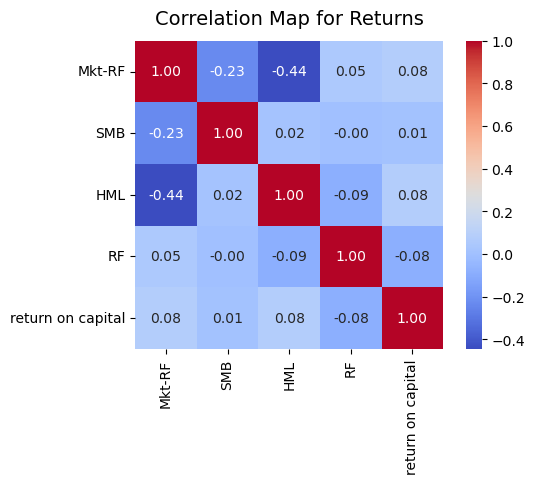

In [144]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(df_temp1.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True) 
ax.set_title('Correlation Map for Returns', fontdict={'fontsize': 14}, pad=12)
plt.show()

#### Return Decomposition 

* 'const' coefficient is positive (3.449e-06) and statistically significant (p-value = 0.001), meaning there is a significant intercept for the model. This also suggests that we generate a very low but positive alpha that is not correlated with the three Fama factors. However, we need to do investigation about this to ensure this is pure luck or skill.
* 'Mkt-RF' has a positive coefficient (3.158e-06) with a p-value of 0.04, indicating a statistically significant relationship with the return on capital at the 5% level. Also, the statistic suggests that the trading strategy is positively correlated with the market factor, which means that the trading strategy is positively correlated with the return on a region's value-weight market portfolio minus the U.S. one month T-bill rate. The value of the beta also corresponds with the correlation calculated before. 
* 'SMB' has a positive but not statistically significant coefficient (2.375e-06), as its p-value (0.346) is above the typical alpha level of 0.05. The value itself is also very small itself, saying that it only explains a little part of our trading strategy. 
* 'HML' also has a positive coefficient (4.544e-06) and is statistically significant with a p-value of 0.005, suggesting a strong relationship with the return on capital.

In [145]:
X = sm.add_constant(df_temp1.loc[:,['Mkt-RF','SMB','HML']])
Y = df_temp1['return on capital']
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      return on capital   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.849
Date:                Thu, 25 Jan 2024   Prob (F-statistic):            0.00967
Time:                        14:15:35   Log-Likelihood:                 4376.3
No. Observations:                 471   AIC:                            -8745.
Df Residuals:                     467   BIC:                            -8728.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.449e-06   1.04e-06      3.318      0.0

#### Rolling Regression Analysis 

The analysis of the rolling betas indicates that the trading strategy's performance is influenced to some degree by the market risk premium and the value factor, while the size factor's influence is minimal and not statistically significant. The positive alpha suggests that after accounting for these Fama-French factors, the strategy is still generating positive returns.

The variation in betas over time also highlights the dynamic nature of the strategy's exposure to these risk factors. We may need to do more analysis and stress testing/ risk management when in periods of siginificant shifts in beta values. 



In [203]:
rolling_reg = rolling_regression_param(df_temp1.loc[:,['Mkt-RF','SMB','HML']],df_temp1['return on capital'],60)
rolling_reg.index = df_temp1.index 
rolling_reg.dropna(inplace=True) 
rolling_reg

,const,Mkt-RF,SMB,HML
date,,,,
2022-03-29,1.023788e-05,-6.931255e-07,3.400101e-06,-0.000006
2022-03-30,1.014350e-05,-5.339990e-07,3.258679e-06,-0.000005
2022-03-31,9.836066e-06,-3.694255e-07,2.935668e-06,-0.000005
2022-04-01,9.665226e-06,-4.370209e-07,2.811069e-06,-0.000005
2022-04-04,9.265638e-06,-2.006113e-07,2.811942e-06,-0.000005
...,...,...,...,...
2023-11-09,1.140372e-06,2.357632e-06,-8.470443e-07,0.000005
2023-11-10,1.142840e-06,2.239007e-06,-5.703533e-07,0.000005
2023-11-13,8.041330e-07,2.109598e-06,-3.423626e-07,0.000005


In [204]:
fig = go.Figure()
for c in rolling_reg.columns: 
    fig.add_trace(
                go.Scatter(x=rolling_reg.index, y=rolling_reg[c], name=c),
            )

fig.update_layout(
    template="none",
    autosize=True,  
    title_text='Beta of rolling regreesion',
    showlegend=True,
    xaxis_title='Date',     
    yaxis_title='Beta',   
)
fig.show()

In [207]:
for c in rolling_reg.columns:  
    print('The mean of rolling regression parameter', c, 'beta is', rolling_reg[c].mean())

The mean of rolling regression parameter const beta is 3.263885376244155e-06
The mean of rolling regression parameter Mkt-RF beta is 2.6829033841029532e-06
The mean of rolling regression parameter SMB beta is -5.243422458215524e-07
The mean of rolling regression parameter HML beta is 5.560824659552963e-06


### 4.4 Profitability and Trading Efficiency

* Win/Loss Ratio: Approximately 1.511, meaning there are roughly 1.511 winning trades for every losing trade.
* Average Win to Average Loss Ratio: Approximately 1.704, indicating that the average winning trade is slightly larger than the average losing trade.
* Average Win: Around $44331 per winning trade.
* Average Loss: About $26013 per losing trade.

Those statistics show taht the average win is far larger than the average loss and the chance of winning is more than the chance of lossing. 

We are trading 18.68% of the time, which should be improved. 

In [214]:
trade_profitability_analysis(optimal)

{'win_loss_ratio': 1.5106382978723405,
 'average_win_loss_ratio': 1.7041722862399418,
 'average_win': 44331.61464459313,
 'average_loss': -26013.575624097073}

In [221]:
len(optimal[optimal['trade_signal'] != 0])/len(optimal)

0.18683651804670912

### 4.5 SVOL ETF Correlation

In [222]:
temp_2 = ETF_data['SVOL_adj_close'] 
temp_2 = temp_2.to_frame()
temp_2['return on capital'] = df_temp1['return on capital']
temp_2.dropna(inplace = True)
temp_2.rename(columns = {'SVOL_adj_close': 'SVOL level'}, inplace = True)

#### Correlation test 

The correlation between our trading strategy and the SVOL ETF appears to be low, indicating that there may not be a strong connection between the two. However, it's worth noting that the products we utilized to construct the trading strategy exhibit a moderate correlation with SVOL, which is somewhat unexpected. Also, since the SVOL negatively correlated with the market volatility, I would assume that it further proves our trading strategy is positively correlated with the market volatility, which helps us to infer the trading rate. Since if the return spread moves often in and out of the threshold range, we have more chances to enter and exist the market. 

In [223]:
temp_2.corr() 

,SVOL level,return on capital
SVOL level,1.000000,0.017461
return on capital,0.017461,1.000000


In [224]:
ETF_data.loc[:,['SVOL_adj_close','RTH_adj_close','XRT_adj_close']].corr()

,SVOL_adj_close,RTH_adj_close,XRT_adj_close
SVOL_adj_close,1.000000,0.792285,0.588972
RTH_adj_close,0.792285,1.000000,0.736848
XRT_adj_close,0.588972,0.736848,1.000000


#### Visual Inspection 

The data exhibit a wide range, so I rescale the return on capital. I multiply return on capital with 10000, and the line chart does not show any siginificant pattern, which means the connection may be subtle and can not see from the general graph, more specefic test and analysis should be conducted. 

In [225]:
fig = go.Figure()
 
fig.add_trace(
            go.Scatter(x=temp_2.index, y=temp_2['SVOL level'], name='SVOL level'),
        )
fig.add_trace(
            go.Scatter(x=temp_2.index, y=temp_2['return on capital']*100000, name='return on capital'),
        )
fig.update_layout(
    template="none",
    autosize=True,  
    title_text='Return for trading strategy and SVOL',
    showlegend=True,
    xaxis_title='Date',     
    yaxis_title='Return',   
)
fig.show()

#### Granger causality tests

Given the p-values from different versions of the test (all above the 0.05 threshold), we can infer that the lagged values of SVOL level do not have a statistically significant predictive power over the return on capital. This suggests that there is no evidence to reject the null hypothesis of no Granger causality from SVOL return to return on capital for the lag length tested. This implies that changes in SVOL return may not be predictive of changes in the return on capital, at least within the scope of the data and lags tested.

In [226]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(np.column_stack([temp_2['SVOL level'], temp_2['return on capital']]), maxlag=[30])


Granger Causality
number of lags (no zero) 30
ssr based F test:         F=1.1443  , p=0.2784  , df_denom=380, df_num=30
ssr based chi2 test:   chi2=39.8406 , p=0.1080  , df=30
likelihood ratio test: chi2=38.1425 , p=0.1461  , df=30
parameter F test:         F=1.1443  , p=0.2784  , df_denom=380, df_num=30


{30: ({'ssr_ftest': (1.1443257146316128, 0.2784200894285675, 380.0, 30),
   'ssr_chi2test': (39.84060316993747, 0.10798861647947984, 30),
   'lrtest': (38.142510448183884, 0.14612473949148294, 30),
   'params_ftest': (1.1443257146316863, 0.2784200894284845, 380.0, 30.0)},
   array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 0., 0., ..., 0., 1., 0.]])])}

#### Regression Test 

A very small negative beta shown in the summary table below, which matches the result before. Also, meaning that SVOL may be not a good ETF to hedge out the risk. 

In [233]:
temp_2['svol_returns'] = ETF_data['SVOL_adj_close'].pct_change(15)
temp_2 = temp_2.dropna()

In [234]:
X = sm.add_constant(temp_2['svol_returns'])  
y = temp_2['return on capital']
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      return on capital   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.07895
Date:                Thu, 25 Jan 2024   Prob (F-statistic):              0.779
Time:                        18:46:20   Log-Likelihood:                 4282.7
No. Observations:                 462   AIC:                            -8561.
Df Residuals:                     460   BIC:                            -8553.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.556e-06   1.07e-06      3.337      0.001    1.46e-06    5.65e-06
svol_returns -9.534e-06   3.39e-05     -0.281      0.779   -7.62e-05    5.71e-05
==============================================================================
Omnibus:                      421.841   Durbin-Watson:                   2.212
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15918.608
Skew:                           3.809   Prob(JB):                         0.00
Kurtosis:                      30.729   Cond. No.                         31.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5. Conclusion 

**best parameters set: M = 15, upper_threshold = 0.03901722201256013, lower_threshold = 0.03372223488961955, stop_loss_rate = 0.01, transaction_cost_rate = 0**

The information presented above includes the best parameters we have discovered and the corresponding return on capital calculations. In-depth discussions for each section can be found at the outset of each respective section. From the best parameters we had, I infer that when the window is relatively short, and the threshold range is relatively small, we can enter and exist the market more frequently, leading to a higher return since number of trades increases. 

However, there are still many areas that I might need to improve. 

Firstly, it's worth noting that the objective function is dependent on the findings obtained earlier, which may limit its coverage of the entire parameter range. A more in-depth reserach regarding the range and the contribution of paramaters should be conducted. 

Secondly, our testing was conducted with a sample size of only 5000 trials, potentially leaving room for better parameters within this specified range. That beging said, I can not draw the conclusion that this is the best parameters for this pair of products. In addition, since it utilizes the simulation, if we re-run the function, the result of best parameters will highly likely to change, 

Thirdly, the method employed for parameter discovery may not be the most efficient, especially when dealing with larger datasets. The objective function takes around 18 minutes to run. If the dataset is larger or the number of simulations increases, this method of finding the best parameters may not work. 

In addition, the return spread is a little bit skewed, if employing the method that "enters or maintains a position if the size of difference $z$ between the M-day return on X and Y is greater than g, and flattens (exits) the nosition if the size of the difference is less than j (where j < a)", to some degree, we assume that the spread return centers at zero. Therefore, we may modify the trading strategy in order to consider the skewness of the return spread. 

Regarding the investigation aspect, there are additional tests (more specefic ones) and analyses that we did not explore, we focus primarily on more general ones.

## 6. Reference 

Data: 
* Help to get data: https://data.nasdaq.com/databases/EOD
* Help to understand data: https://www.nasdaq.com/market-activity/etf 

Strategy: 
* Analysis related to mean reversion strategy: https://www.pythonforfinance.net/2016/05/09/python-backtesting-mean-reversion-part-2/
* Some insights of writing strategy: https://raposa.trade/blog/how-to-build-your-first-mean-reversion-trading-strategy-in-python/

Code: 
* For the rolling regression and performance metrics, I utilize the codes wrote by TA in Portfolio HW 2. 